Time: 0
Time: 10
Time: 20
Time: 30
Time: 40
Time: 50
Time: 60
Time: 70
Time: 80
Time: 90
1 859
2 0
3 584
4 662
5 0
2 850
3 0
4 9
5 242
6 0
2 44
3 100
4 5
5 69
6 101


C:\Users\Jason\AppData\Local\Temp\ipykernel_16552\2194177942.py:723: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5348837209302325' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.iloc[row] = X.iloc[row] / X.iloc[row].sum()
C:\Users\Jason\AppData\Local\Temp\ipykernel_16552\2194177942.py:723: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.46511627906976744' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.iloc[row] = X.iloc[row] / X.iloc[row].sum()
C:\Users\Jason\AppData\Local\Temp\ipykernel_16552\2194177942.py:723: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5757575757575758' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.iloc[row] = X.ilo

Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 392 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 5213 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [y_obs]


Sampling: [alpha, beta, beta_mu, beta_sd, y_obs]


              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta_mu[0]  -8.718  3.719 -15.282   -1.872      0.811    0.581      22.0   
beta_mu[1]   2.279  5.333  -7.412   13.115      1.026    0.734      27.0   
beta_mu[2]   0.732  5.368  -7.420   11.791      1.201    0.862      20.0   
beta_mu[3]   1.594  5.026  -8.553   11.669      0.544    0.406      83.0   
beta_mu[4]  11.001  4.262   2.561   18.086      1.084    0.795      15.0   
...            ...    ...     ...      ...        ...      ...       ...   
p[40, 10]    0.001  0.010   0.000    0.000      0.000    0.000      67.0   
p[40, 11]    0.001  0.012   0.000    0.000      0.000    0.000      13.0   
p[40, 12]    0.001  0.009   0.000    0.000      0.000    0.000     167.0   
p[40, 13]    0.001  0.008   0.000    0.000      0.000    0.000      15.0   
p[40, 14]    0.001  0.009   0.000    0.000      0.000    0.000      76.0   

            ess_tail  r_hat  
beta_mu[0]     191.0   1.12  
beta_mu[1]      32.0   1.11

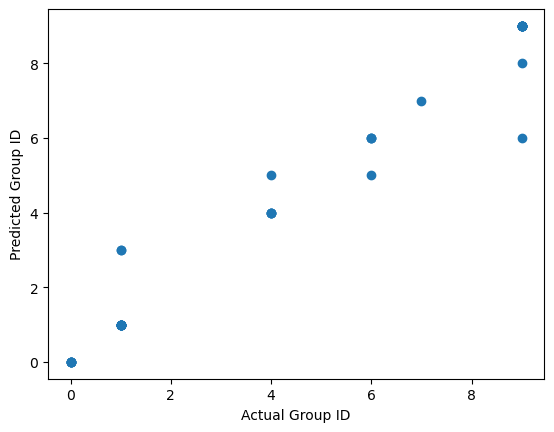

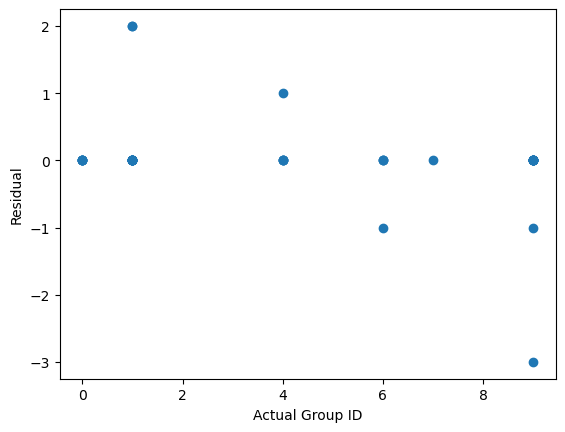

              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
beta_mu[0]  -8.718  3.719 -15.282   -1.872      0.811    0.581      22.0   
beta_mu[1]   2.279  5.333  -7.412   13.115      1.026    0.734      27.0   
beta_mu[2]   0.732  5.368  -7.420   11.791      1.201    0.862      20.0   
beta_mu[3]   1.594  5.026  -8.553   11.669      0.544    0.406      83.0   
beta_mu[4]  11.001  4.262   2.561   18.086      1.084    0.795      15.0   
...            ...    ...     ...      ...        ...      ...       ...   
p[40, 10]    0.001  0.010   0.000    0.000      0.000    0.000      67.0   
p[40, 11]    0.001  0.012   0.000    0.000      0.000    0.000      13.0   
p[40, 12]    0.001  0.009   0.000    0.000      0.000    0.000     167.0   
p[40, 13]    0.001  0.008   0.000    0.000      0.000    0.000      15.0   
p[40, 14]    0.001  0.009   0.000    0.000      0.000    0.000      76.0   

            ess_tail  r_hat  
beta_mu[0]     191.0   1.12  
beta_mu[1]      32.0   1.11

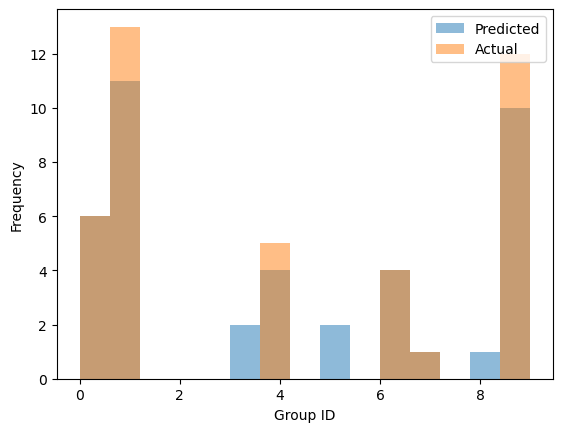

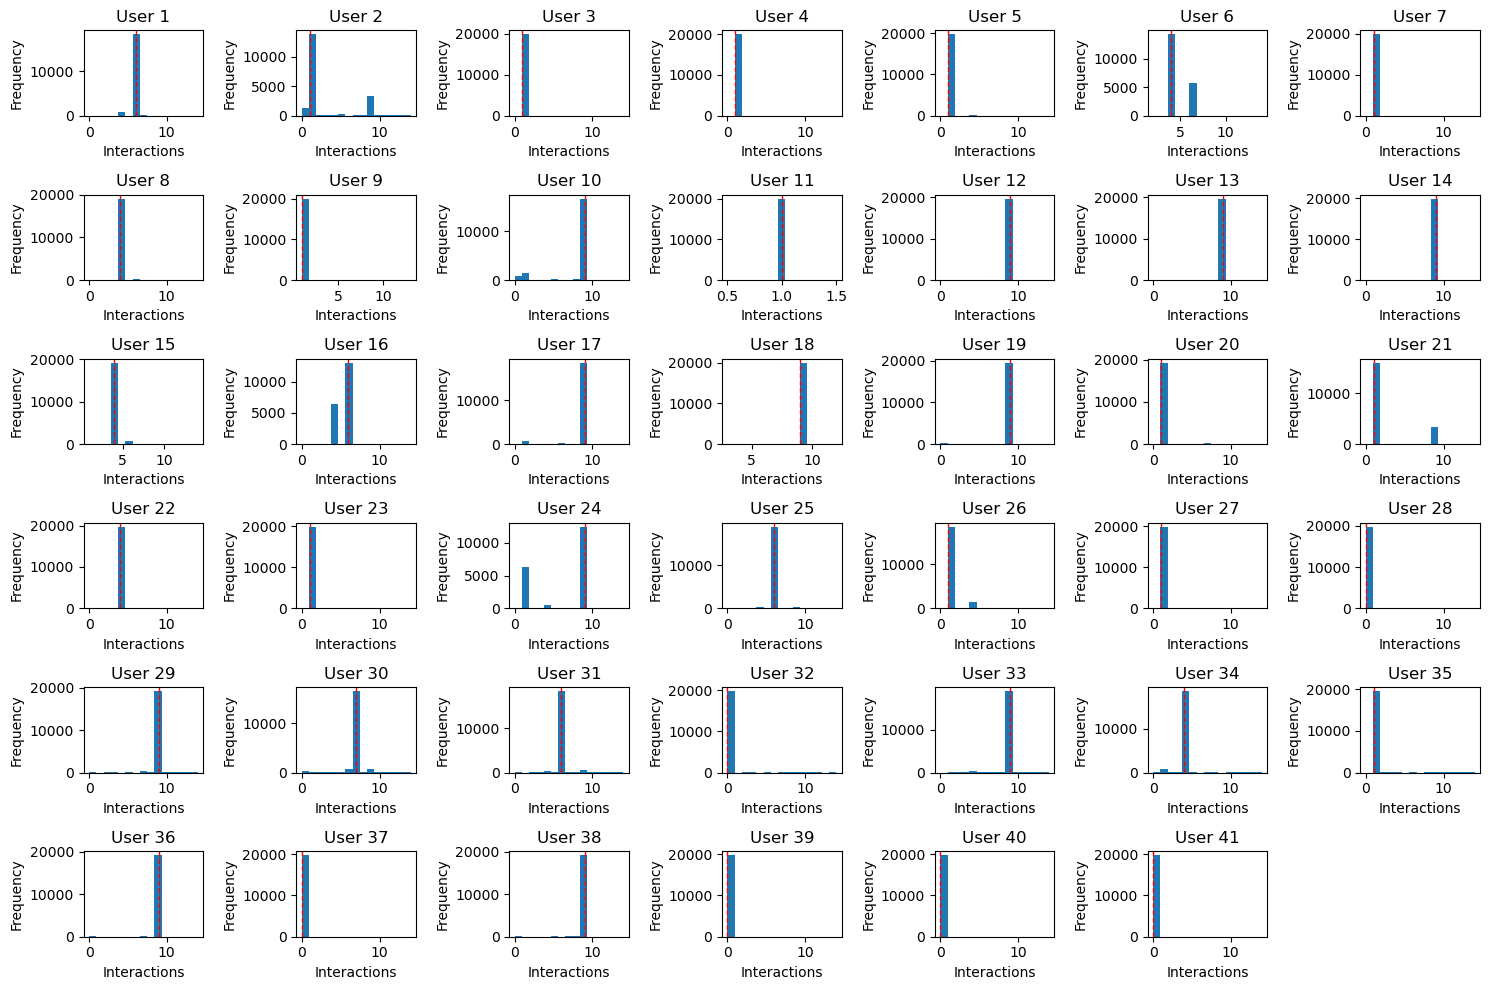

In [24]:
import numpy as np
from scipy import stats
import math
from math import floor
import argparse
import matplotlib.pyplot as plt
import os
import csv
import pymc as pm
import arviz as az
import warnings
import pandas as pd 

class Simulation:

    ## Fixed hyperparameters


    initial_users = 20
    initial_groups = 10
    initial_communities = 5

    # group and community preferences
    alpha_group_hyperparameter = 10
    beta_group_hyperparameter = 10 

    alpha_community_hyperparameter = 10
    beta_community_hyperparameter = 10

        
    # Initialize lists to store users and groups
    users = []
    groups = []
    communities = []


    gis = {}
    cis = {}
    uis = {}

    def __init__(self,num_timesteps, user_growth_rate, interaction_threshold, new_group_rate, new_community_rate) -> None:

        self.num_timesteps = num_timesteps

        self.user_growth_rate = user_growth_rate

        self.interaction_threshold = interaction_threshold

        self.new_group_rate = new_group_rate
        self.new_group_join_chance = new_group_rate / 10

        self.new_community_rate = new_community_rate
        self.new_community_join_chance = new_community_rate / 10

        self.same_community_interaction_ratio = new_community_rate * new_group_rate

    class Community:
        def __init__(self, simulation, group=None):
            self.simulation = simulation 
            # Initialize a community with a list of users and groups
            self.id = len(self.simulation.communities) + 1
            self.groups = [group] if group else []
            self.interactions = []

    class Group:
        def __init__(self, simulation):
            self.simulation = simulation 
            # Initialize a group with an ID and a dictionary tgo track user interactions
            self.id = len(self.simulation.groups) + 1
            self.interactions = {}
            self.community = None

        def join_community(self, community):
            community.groups.append(self)
            self.community = community

    class User:
        def __init__(self, group_alpha, group_beta, community_alpha, community_beta):
            # Initialize a user with ID, group memberships, interaction history, and Beta distribution preferences
            self.id = None

            self.groups = []
            self.communities = []
            self.interaction_history = []

            self.group_preferences = stats.beta(group_alpha, group_beta)
            self.community_preferences = stats.beta(community_alpha, community_beta)
            self.updated_preferences = np.array([1])

        def update_preferences(self):
            # Update user's preferences based on group interactions
            if not self.groups:
                self.updated_preferences = np.array([1])
                return
            else:
                #sort groups by number of interactions
                self.groups.sort(key=lambda group: len(group.interactions))

            total_size = sum([len(group.interactions) for group in self.groups])

            # if size is 0, this must be the first iteration, return uniform
            if total_size == 0:
                self.ccdf = np.array([1])
                return
            else:
                sizes = sorted([len(group.interactions) for group in self.groups])
                self.ccdf = 1 - (np.cumsum(sizes) / total_size)

            group_convolution = np.convolve(self.group_preferences.pdf(np.linspace(0, 1, len(self.groups))), self.ccdf , mode='same')

            self.updated_preferences = np.convolve(group_convolution, self.community_preferences.pdf(np.linspace(0, 1, len(self.groups))), mode='same')

            if np.isnan(self.updated_preferences).any() or np.sum(self.updated_preferences) == 0:
                self.updated_preferences = np.array([1 / len(self.groups)] * len(self.groups))
            else:
                self.updated_preferences /= np.sum(self.updated_preferences)

        def join_group(self, group):
            # Add a group to the user's group list and set initial interactions to 0
            self.groups.append(group)
            group.interactions[self] = 0

        def interact(self, group):
            # Record an interaction with the specified group
            group.interactions[self] = group.interactions.get(self, 0) + 1
            self.interaction_history.append(group.id)

    # Recalculate probabilities at every iteration or after any changes
    def calculate_probabilities(self):
        global community_relative_frequency, group_relative_frequency

        community_relative_frequency = np.array([len(community.groups) for community in self.communities], dtype=float)
        # if community_relative_frequency.sum() != 0:
        community_relative_frequency += 1e-5  # Avoid division by zero
        community_relative_frequency /= community_relative_frequency.sum()

        group_relative_frequency = np.array([sum(group.interactions.values()) for group in self.groups], dtype=float)
        # if group_relative_frequency.sum() != 0:
        group_relative_frequency += 1e-5
        group_relative_frequency /= group_relative_frequency.sum()


    def initialize(self):

        # Initialize users
        for i in range(self.initial_users):
            self.users.append(
                self.User(
                    self.alpha_group_hyperparameter,
                    self.beta_group_hyperparameter,
                    self.alpha_community_hyperparameter,
                    self.beta_community_hyperparameter,
                )
            )
            self.users[-1].id = len(self.users)

        # Initialize communities
        for i in range(self.initial_communities):
            self.communities.append(self.Community(self))

        # Initialize groups
        for i in range(self.initial_groups):
            self.groups.append(self.Group(self))

        # adding the first groups to each community so there is at least one group in each community
        for i in range(len(self.communities)):
            self.groups[i].join_community(self.communities[i])
            # random chance for each user to join the first group of a new community
            for user in self.users:
                if np.random.random() < self.new_community_join_chance:
                    user.join_group(self.groups[i])

        # randomly adding the rest of the groups to communities
        for group in self.groups[len(self.communities):]:
            group.join_community(self.communities[np.random.randint(0, len(self.communities))])
            for user in self.users:
                if np.random.random() < self.new_group_join_chance:
                    user.join_group(group)

        # initialize dictionaries for each group, community, and user
        for group in self.groups:
            self.gis[group.id] = []
        for community in self.communities:
            self.cis[community.id] = []
        for user in self.users:
            self.uis[user.id] = []

        
    def run(self):
        # main loop
        for time in range(self.num_timesteps):
            if time % 10 == 0:
                print(f"Time: {time}")
            # Calculate probabilities
            self.calculate_probabilities()

            # Add new users
            new_users_count = floor(np.random.exponential(self.user_growth_rate))
            for i in range(new_users_count):
                self.users.append(
                    self.User(
                        self.alpha_group_hyperparameter,
                        self.beta_group_hyperparameter,
                        self.alpha_community_hyperparameter,
                        self.beta_community_hyperparameter,
                    )
                )
                self.users[-1].id = len(self.users)

            # Add new groups
            new_groups_count = floor(np.random.exponential(self.new_group_rate))
            for i in range(new_groups_count):
                self.groups.append(self.Group(self))

                # a new community always get made on the first time step
                if time == 0:
                    if new_groups_count == 0:
                        self.groups.append(self.Group(self))
                    self.groups[-1].join_community(self.communities[-1])
                    self.communities[-1].groups.append(self.groups[-1])
                else:
                    # check if the new group forms a new community
                    if np.random.random() < self.new_community_rate:
                        self.communities.append(self.Community(self, self.groups[-1]))
                        self.groups[-1].community = self.communities[-1]
                        # each user has a chance to join the new community
                        for user in self.users:
                            if np.random.random() < self.new_community_join_chance:
                                user.join_group(self.groups[-1])
                        # users[np.random.randint(0, len(users))].join_group(groups[-1])
                    else:
                        # join a random community
                        self.groups[-1].join_community(self.communities[np.random.randint(0, len(self.communities))])

            # Updating dictionaries with new groups, communities, and users
            # and setting their initial values to 0
            for group in self.groups:
                if group.id not in self.gis:
                    self.gis[group.id] = [0]
                self.gis[group.id].append(0)
            for community in self.communities:
                if community.id not in self.cis:
                    self.cis[community.id] = [0]
                self.cis[community.id].append(0)
            for user in self.users:
                if user.id not in self.uis:
                    self.uis[user.id] = [0]
                self.uis[user.id].append(0)

            # Add new users to groups
            for user in self.users:
                self.calculate_probabilities()
                # if there are groups for the user to join that they aren't in
                if len(user.groups) < len(self.groups):
                    # join a group
                    if np.random.random() < self.new_group_join_chance:
                        user.join_group(self.groups[np.random.choice(len(self.groups), p=group_relative_frequency)])

            # Interact with groups
            for user in self.users:
                user.update_preferences()
                interacted_groups = []
                if np.random.uniform() < self.interaction_threshold and user.groups:
                    # print(user.updated_preferences)
                    group = np.random.choice(user.groups, p=user.updated_preferences)
                    user.interact(group)
                    self.gis[group.id][-1] += 1
                    self.cis[group.community.id][-1] += 1
                    self.uis[user.id][-1] += 1

                    # potential bonus interactions within another group in the same community
                    if group.community:
                        while True:
                            if np.random.uniform() < self.same_community_interaction_ratio:
                                community = group.community                    
                                group = np.random.choice(community.groups)
                                user.interact(group)
                                self.gis[group.id][-1] += 1
                                self.cis[group.community.id][-1] += 1
                                self.uis[user.id][-1] += 1
                            else:
                                break

            # Update user preferences
            for user in self.users:
                if user.groups:
                    user.update_preferences()
                    if user.id == 0:
                        print(user.updated_preferences)
                        print(user.group_preferences.pdf(np.linspace(0, 1, len(user.groups))))
                else:
                    user.updated_preferences = np.array([1])

    def plot(self, sim_number):        
        directory_name = f"{self.user_growth_rate}_{self.interaction_threshold}_{self.new_group_rate}_{self.new_community_rate}/{sim_number}"
        os.makedirs(directory_name, exist_ok=True)

        c_sum = []
        c_sum_labels = []
        for i in range(len(self.communities)):
            temp_sum = [0] * self.num_timesteps
            c_vals = np.cumsum(self.cis[i+1])
            # add the values starting from the back
            for j, val in enumerate(reversed(c_vals)):
                temp_sum[-1-j] = val
            c_sum.append(temp_sum)
            c_sum_labels.append(list(self.cis.keys())[i])

        # print the final value for each community
        for c in c_sum_labels[:5]:
            print(c, c_sum[c_sum_labels.index(c)][-1])
            
        # finding the labels for the 5 largest communities
        top_5 = []
        top_5_labels = []
        for i in range(5):
            max_val = 0
            max_index = 0
            for j in range(len(c_sum)):
                if c_sum[j][-1] > max_val and c_sum_labels[j] not in top_5_labels:
                    max_val = c_sum[j][-1]
                    max_index = j
            top_5.append(c_sum[max_index])
            top_5_labels.append(c_sum_labels[max_index])

        for i in range(len(c_sum)):
            if c_sum_labels[i] in top_5_labels:
                plt.plot(c_sum[i][:len(c_sum[i])], label=f"C{i+1}")
            else:
                plt.plot(c_sum[i][:len(c_sum[i])], label=None)

        plt.legend(loc="upper left")
        plt.xlabel("Time")
        plt.ylabel("Cumulative Interactions")
        plt.yscale("log")
        plt.title("Cumulative Interactions of Each Community Over Time")
        plt.savefig(f"{directory_name}/community_interaction_growth.png")
        plt.close()
        
        # Scatter plot for final amount of interactions for each community
        c_sum_final = []
        c_sum_final_labels = []
        for i in range(len(self.communities)):
            c_sum_final.append(c_sum[i][-1])
            c_sum_final_labels.append(list(self.cis.keys())[i])

        plt.scatter(c_sum_final_labels, c_sum_final)
        plt.xlabel("Community")
        plt.ylabel("Final Cumulative Interactions")
        plt.title("Final Cumulative Interactions of Each Community")
        plt.savefig(f"{directory_name}/final_community_interactions.png")
        plt.close()
        

        g_sum = []
        g_sum_labels = []
        for i in range(1, len(self.groups)):
            temp_sum = [0] * self.num_timesteps
            g_vals = np.cumsum(self.gis[i])
            # add the values starting from the back
            for j, val in enumerate(reversed(g_vals)):
                try:
                    temp_sum[j] = val
                except:
                    pass

            temp_sum = temp_sum[::-1]
            g_sum.append(temp_sum)
            g_sum_labels.append(list(self.gis.keys())[i])

        # print the final value for each group
        for g in g_sum_labels[:5]:
            print(g, g_sum[g_sum_labels.index(g)][-1])

        # finding the labels for the 5 largest groups
        top_5 = []
        top_5_labels = []
        for i in range(5):
            max_val = 0
            max_index = 0
            for j in range(len(g_sum)):
                if g_sum[j][-1] > max_val and g_sum_labels[j] not in top_5_labels:
                    max_val = g_sum[j][-1]
                    max_index = j
            top_5.append(g_sum[max_index])
            top_5_labels.append(g_sum_labels[max_index])

        for i in range(len(g_sum)):
            if g_sum_labels[i] in top_5_labels:
                plt.plot(g_sum[i], label=f"G{i+1}")
            else:
                plt.plot(g_sum[i], label=None)

        plt.legend(loc="upper left")
        plt.xlabel("Time")
        plt.ylabel("Cumulative Interactions")
        # plt.yscale("log")
        plt.ylim(bottom=1)
        plt.title("Cumulative Interactions of Each Group Over Time")
        plt.savefig(f"{directory_name}/group_interaction_growth.png")
        plt.close()

        # Scatter plot for final amount of interactions for each group
        g_sum_final = []
        g_sum_final_labels = []
        for i in range(len(g_sum)):
            g_sum_final.append(g_sum[i][-1])
            g_sum_final_labels.append(list(self.gis.keys())[i])

        plt.scatter(g_sum_final_labels, g_sum_final)
        plt.xlabel("Group")
        plt.ylabel("Final Cumulative Interactions")
        plt.title("Final Cumulative Interactions of Each Group")
        plt.savefig(f"{directory_name}/final_group_interactions.png")
        plt.close()

        for u in self.uis:
            self.uis[u] = self.uis[u][:self.num_timesteps]

        # plotting total amount of interactions for each user
        u_sum = []
        u_sum_labels = []
        for i in range(1, len(self.users)):
            temp_sum = [0] * self.num_timesteps
            u_vals = np.cumsum(self.uis[i])
            # add the values starting from the back
            for j, val in enumerate(reversed(u_vals)):
                temp_sum[j] = val

            temp_sum = temp_sum[::-1]
            u_sum.append(temp_sum)
            u_sum_labels.append(list(self.uis.keys())[i])

        # print the final value for each user
        for u in u_sum_labels[:5]:
            print(u, u_sum[u_sum_labels.index(u)][-1])

        # finding the labels for the 5 largest users
        top_5 = []
        top_5_labels = []

        for i in range(5):
            max_val = 0
            max_index = 0
            for j in range(len(u_sum)):
                if u_sum[j][-1] > max_val and u_sum_labels[j] not in top_5_labels:
                    max_val = u_sum[j][-1]
                    max_index = j
            top_5.append(u_sum[max_index])
            top_5_labels.append(u_sum_labels[max_index])

        # Scatter plot for final amount of interactions for each user
        u_sum_final = []
        u_sum_final_labels = []
        for i in range(len(u_sum)):
            u_sum_final.append(u_sum[i][-1])
            u_sum_final_labels.append(list(self.uis.keys())[i])

        plt.scatter(u_sum_final_labels, u_sum_final)
        plt.xlabel("User")
        plt.ylabel("Final Cumulative Interactions")
        plt.title("Cumulative Interactions of Each User")
        plt.savefig(f"{directory_name}/final_user_interactions.png")
        plt.close()

    
    def write_data(self, sim_number):
        directory_name = f"{self.user_growth_rate}_{self.interaction_threshold}_{self.new_group_rate}_{self.new_community_rate}/{sim_number}"
        os.makedirs(directory_name, exist_ok=True)

        # Write User Interactions to CSV
        with open(f"{directory_name}/user_interactions.csv", 'w', newline='') as file:
            writer = csv.writer(file)
            for row in self.uis:
                writer.writerow([row] + self.uis[row])

            file.close()
        
        # Write Group Interactions to CSV
        with open(f"{directory_name}/group_interactions.csv", 'w', newline='') as file:
            writer = csv.writer(file)
            for row in self.gis:
                writer.writerow([row] + self.gis[row])

            file.close()

        # Write Community Interactions to CSV
        with open(f"{directory_name}/community_interactions.csv", 'w', newline='') as file:
            writer = csv.writer(file)
            for row in self.cis:
                writer.writerow([row] + self.cis[row])

            file.close()


        with open(f"{directory_name}/simulation_data.csv", 'w') as file:
            writer = csv.writer(file)
            writer.writerow(['num_users', 'num_groups', 'num_communities', 'num_interactions'])
            writer.writerow([len(self.users), len(self.groups), len(self.communities), sum([len(group.interactions) for group in self.groups])])

            file.close()

        print("Data written to CSV files.")

    def community_regression_model(self):

        y = []
        X = []
        c_sum = 0

        for community in range(len(self.communities)):
            df = pd.DataFrame(self.cis[community + 1]) - pd.DataFrame(self.cis[community + 1]).shift(1)
            df.fillna(0, inplace=True)
            X.append(df)
            c = pd.DataFrame(self.cis[community + 1])
            c_sum += c.sum()            

        # get rid of third dimension of X
        X = np.array(X)
        X = X.reshape(X.shape[0], X.shape[1])

            
        X = pd.DataFrame(X)

        y = X.iloc[:,-1]
        y.fillna(0, inplace=True)

        X = X.iloc[:,:-1]
        X.fillna(0, inplace=True)

        y = y.to_numpy()

        model = pm.Model()

        with model:
            try:
                # Data
                group_index = pm.Data('group_index', np.arange(len(self.communities)), dims='community')
                X_data = pm.Data('X_data', X.T)
                y_data = pm.Data('y_data', y)

                # Priors
                rho = pm.Normal('phi', mu=0, sigma=10, dims='community')
                sigma_ar = pm.Exponential('sigma_ar', lam=1)

                # AR Model
                ar = pm.AR('ar', rho=rho, sigma=sigma_ar, dims='community')


                # Likelihood
                sigma = pm.Exponential('sigma', lam=1)
                y_obs = pm.Normal('y_obs', mu=ar, sigma=sigma, observed=y_data, dims='community')

                # Sampling
                trace = pm.sample(tune=1000, draws=1000)
                posterior_predictive = pm.sample_posterior_predictive(trace)
                prior_predictive = pm.sample_prior_predictive()
            
            except pm.exceptions.SamplingError:
                warnings.warn('SamplingError: Skipping this group')

        prior = prior_predictive['prior_predictive']['y_obs']

        cs = [[] for _ in range(len(self.communities))]

        for chain in range(prior.shape[0]):
            for draw in range(prior.shape[1]):
                for c in range(prior.shape[2]):
                    cs[c].append(prior[chain,draw,c])

        for c in cs:
            plt.hist(c)
        plt.show()

        pred = posterior_predictive['posterior_predictive']['y_obs'].to_numpy()

        shape = pred.shape
        groups1 = shape[2]

        # Initialize list of lists for each community
        preds = [[] for _ in range(groups1)]

        for i in range(shape[0]):
            for j in range(shape[1]):
                for k in range(groups1):
                    preds[k].append(pred[i, j, k])

        for k in range(groups1):

            plt.hist(preds[k], bins=50, alpha=0.5)
            plt.axvline(y[k], color='k', linestyle='dashed', linewidth=1)
            plt.title('Community Interaction Predictions')
            plt.xlabel("Number of interactions")
            plt.ylabel("Frequency")
        plt.show()
            
        print(az.summary(trace))

    
    def group_regression_model(self):

        y = []
        X = []
        g_sum = 0

        for group in range(len(self.groups)):
            df = pd.DataFrame(self.gis[group + 1]) - pd.DataFrame(self.gis[group + 1]).shift(1)
            df.fillna(0, inplace=True)
            X.append(df)
            g = pd.DataFrame(self.gis[group + 1])
            g_sum += g.sum()            

        # get rid of third dimension of X
        X = np.array(X)
        X = X.reshape(X.shape[0], X.shape[1])

            
        X = pd.DataFrame(X)

        y = X.iloc[:,-1]
        y.fillna(0, inplace=True)

        X = X.iloc[:,:-1]
        X.fillna(0, inplace=True)

        y = y.to_numpy()

        model = pm.Model()

        with model:
            try:
                # Data
                group_index = pm.Data('group_index', np.arange(len(self.groups)), dims='group')
                X_data = pm.Data('X_data', X.T)
                y_data = pm.Data('y_data', y)

                # Priors
                rho = pm.Normal('phi', mu=0, sigma=10, dims='group')
                sigma_ar = pm.Exponential('sigma_ar', lam=1)

                # AR Model
                ar = pm.AR('ar', rho=rho, sigma=sigma_ar, dims='group')


                # Likelihood
                sigma = pm.Exponential('sigma', lam=1)
                y_obs = pm.Normal('y_obs', mu=ar, sigma=sigma, observed=y_data, dims='group')

                # Sampling
                trace = pm.sample(tune=1000, draws=1000)
                posterior_predictive = pm.sample_posterior_predictive(trace)
                prior_predictive = pm.sample_prior_predictive()
            
            except pm.exceptions.SamplingError:
                warnings.warn('SamplingError: Skipping this group')

        prior = prior_predictive['prior_predictive']['y_obs']

        gs = [[] for _ in range(len(self.groups))]

        for chain in range(prior.shape[0]):
            for draw in range(prior.shape[1]):
                for g in range(prior.shape[2]):
                    gs[g].append(prior[chain,draw,g])

        for g in gs:
            plt.hist(g)
        plt.show()

        pred = posterior_predictive['posterior_predictive']['y_obs'].to_numpy()

        shape = pred.shape
        groups1 = shape[2]

        # Initialize list of lists for each community
        preds = [[] for _ in range(groups1)]

        for i in range(shape[0]):
            for j in range(shape[1]):
                for k in range(groups1):
                    preds[k].append(pred[i, j, k])

        for k in range(groups1):

            plt.hist(preds[k], bins=50, alpha=0.5)
            plt.axvline(y[k], color='k', linestyle='dashed', linewidth=1)
            plt.title('Group Interaction Predictions')
            plt.xlabel("Number of interactions")
            plt.ylabel("Frequency")
        plt.show()
            
        print(az.summary(trace))
    
    def user_choice_model(self):
        
        # multinomial logit model for group interactions
        num_groups = len(self.groups)
        y = []
        X = []

        for user in self.users:
            if len(user.interaction_history) == 0:
                y.append(0)
            else:
                y.append(user.interaction_history[-1])
            # every interaction but the last one
            X.append(np.bincount(user.interaction_history[:-1], minlength=num_groups))


        X = pd.DataFrame(X)
        X.fillna(0, inplace=True)

        y = pd.DataFrame(y)
        y = y.iloc[:,0]

        # drop first column if sum is 0
        if X.iloc[:,0].sum() == 0:
            X = X.iloc[:,1:]
            # if num_groups != X.shape[1]:
            #    num_groups -= (X.shape[1] - num_groups)
        
        for row in range(len(X)):
            X.iloc[row] = X.iloc[row] / X.iloc[row].sum()

        X.fillna(0, inplace=True)
        X = (X - X.mean()) / X.std()
        X.fillna(0, inplace=True)


        model = pm.Model()


        with model:
            try:

                indices = pm.Data('index', list(range(len(X))), dims='user')
                # Define your data within the model
                X_data = pm.Data('X_data', X)
                y_data = pm.Data('y_data', y)

                # Model parameters
                
                alpha = pm.Exponential('alpha', lam=np.max(group_relative_frequency), shape=num_groups)

                beta_mu = pm.Normal('beta_mu', mu=1, sigma=10, shape=num_groups)
                beta_sd = pm.TruncatedNormal('beta_sd', lower=0, mu=5, sigma=2.5, shape=num_groups)

                beta = pm.Normal('beta', mu=beta_mu, sigma=beta_sd, shape=(num_groups, num_groups))

                # Computing mu
                mu = alpha + pm.math.dot(X_data, beta) 

                # A numerically stable softmax
                mu_max = pm.math.max(mu, axis=1, keepdims=True)
                p = pm.Deterministic('p', pm.math.exp(mu - mu_max) / pm.math.sum(pm.math.exp(mu - mu_max), axis=1, keepdims=True))

                # Categorical distribution for observed data
                y_obs = pm.Categorical('y_obs', p=p, observed=y_data, dims='user')

                # Sampling
                trace = pm.sample(tune=5000, draws=5000)
                posterior_predictive = pm.sample_posterior_predictive(trace)
                prior_predictive = pm.sample_prior_predictive()

            except pm.exceptions.SamplingError:
                model.debug(verbose=True)
            
            print(az.summary(trace))

            y_pred = np.rint(posterior_predictive['posterior_predictive']['y_obs'].mean(axis=(0,1))) 

            plt.scatter(y, y_pred)
            plt.xlabel('Actual Group ID')
            plt.ylabel('Predicted Group ID')
            plt.show()

            plt.scatter(y, y_pred - y)
            plt.xlabel('Actual Group ID')
            plt.ylabel('Residual')
            plt.show()

            print(az.summary(trace))

            plt.hist(y_pred, bins=num_groups, alpha=0.5, label='Predicted')
            plt.hist(y,  bins=num_groups, alpha=0.5, label='Actual')
            plt.legend(loc='upper right')
            plt.xlabel("Group ID")
            plt.ylabel("Frequency")
            plt.show()
            samples = posterior_predictive['posterior_predictive']['y_obs'].to_numpy()
            users = [[] for _ in range(samples.shape[2])]
            for chain in range(samples.shape[0]):
                for draw in range(samples.shape[1]):
                    for user in range(samples.shape[2]):
                       users[user].append(samples[chain, draw, user])


            # Define the grid layout
            num_users = len(users)
            num_rows = int(num_users**0.5)  # Number of rows in the grid
            num_cols = (num_users + num_rows - 1) // num_rows  # Number of columns in the grid

            # Create subplots
            fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

            # Iterate through users and plot histograms
            for user_idx, ax in enumerate(axes.flat):
                if user_idx < num_users:
                    user_data = users[user_idx]
                    actual_interaction = y[user_idx]

                    ax.hist(user_data, bins=num_groups)
                    ax.axvline(actual_interaction, color='r', linestyle='dashed', linewidth=1)

                    ax.set_title(f'User {user_idx + 1}')
                    ax.set_xlabel('Interactions')
                    ax.set_ylabel('Frequency')

            # Remove any empty subplots
            for user_idx in range(num_users, num_rows * num_cols):
                fig.delaxes(axes.flat[user_idx])

            plt.tight_layout()
            plt.show()

        
sim = Simulation(100, .5, 1.01, 0.25, 0.125)
sim.initialize()
sim.run()
sim.plot(1)
'''
sim.community_regression_model()
sim.group_regression_model()
'''
sim.user_choice_model()